# Import

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
import copy

import scipy.stats as ss
from scipy.stats import norm
from scipy.stats import poisson

# import code
from simulation import Simulation
from replicate_graph import layer_graph
import data
from data import get_station_G, stations_df, distances_df
from visualization import set_draw_attributes

import os

import re

# Create graphs from csv's

In [2]:
stations_df.set_index("OID_").loc[228]["st_prv_cod"]

'CA'

In [3]:
distances_df.head(2)

,Unnamed: 0,OID_,Name,OriginID,DestinationID,DestinationRank,Total_Minutes,Total_TravelTime,Total_Miles,Total_Kilometers,Total_TimeAt1KPH,Total_WalkTime,Total_TruckMinutes,Total_TruckTravelTime,Shape_Length
1,185,186,Location 1 - Location 228,1,228,186,NaN,73.151367,NaN,100.524977,NaN,NaN,NaN,NaN,0.862277
2,290,291,Location 1 - Location 378,1,378,291,NaN,184.181136,NaN,223.777273,NaN,NaN,NaN,NaN,1.989791


In [4]:
increment = 50
station_G = get_station_G()
G = layer_graph(station_G, increment)
G.nodes;

# Visualize general data structure

In [5]:
# print(list(stations_df["OID_"]))
# print(station_G.nodes)
stations_df.head(5)

,OID_,OBJECTID,station_na,fuel_type_,status_cod,street_add,city,st_prv_cod,zip,station_ph,access_day,groups_wit,cards_acce,longitude,latitude,physical_capacity,charging_rate
0,1,14,Scripps Green Hospital,ELEC,AVBL,10666 N Torrey Pines Rd,La Jolla,CA,92037,858-554-9100,24 hours daily,Public,,-117.243000,32.899470,5,50
1,228,24674,CC STATION 1,ELEC,AVBL,24351 El Toro Rd,Laguna Woods,CA,92637,888-758-4389,24 hours daily,Public,,-117.731017,33.610358,4,50
2,378,26140,ORCHARD PARKING,ELEC,AVBL,23839-23851 McBean Pkwy,Santa Clarita,CA,91355,888-758-4389,24 hours daily,Public,,-118.553055,34.397143,5,50
3,447,28934,SACRAMENTO,ELEC,AVBL,City Hall Garage 939 10th Street,Sacramento,CA,95814,888-758-4389,24 hours daily,Public,,-121.493004,38.580975,4,50
4,465,29953,YREKA TRUCK,ELEC,AVBL,787 Montague Rd,Yreka,CA,96097,888-758-4389,24 hours daily,Public,,-122.619092,41.738366,3,50


In [6]:
# Set colors
for node in station_G.nodes:
    station_G.nodes[node]["color"] = "green"
    station_G.nodes[node]["node_size"] = 400
    
station_G.nodes["465"]["color"] = "blue" 
station_G.nodes["1"]["color"] = "blue" 
station_G.nodes["465"]["node_size"] = 400 
station_G.nodes["1"]["node_size"] = 400 

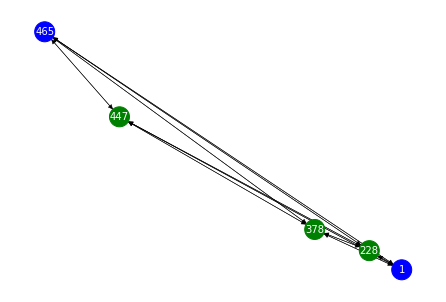

In [7]:
pos=nx.get_node_attributes(station_G,'pos')
color = nx.get_node_attributes(station_G,'color').values()
node_size = list(nx.get_node_attributes(station_G,'node_size').values())
labels = {node:node for node in list(station_G.nodes)}
nx.draw(station_G, pos = pos, node_size=node_size, width=.5, node_color=color, labels = labels, 
        font_color = "white", font_size = 10)

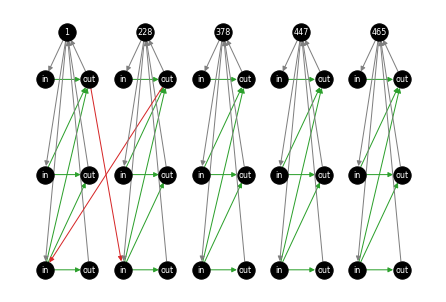

In [8]:
labels = {node:node[-2:] if "in" in node else node[-3:] for node in list(G.nodes)}
pos, edge_colors = set_draw_attributes(G, station_G)
nx.draw(G, pos = pos, labels = labels, edge_color = list(edge_colors.values()), 
        font_size = 8, font_color="white", node_color="black")

# Simulation

In [9]:
sim = Simulation(station_G, 24, 20, 6)
sim.add_dst("465",5)
src_dstr = [10,20,30,40,50,60,50,40,30,20,30,40,50,60,50,40,30,20,10,5,0,0,0,0]
sim.add_src("1",src_dstr)

In [10]:
sim.get_random_destination(1)

array(['465'], dtype='<U3')

In [11]:
sim.run()

In [14]:
for v in sim.vehicle_list:
    print(v.path)

['1', '1_0_in', '1_40_out', '378_0_in', '378_100_out', '447_0_in', '447_80_out', '465_0_in', '465_0_out', '465']
['1', '1_0_in', '1_40_out', '378_0_in', '378_100_out', '447_0_in', '447_80_out', '465_0_in', '465_0_out', '465']
['1', '1_0_in', '1_40_out', '378_0_in', '378_100_out', '447_0_in', '447_80_out', '465_0_in', '465_0_out', '465']
['1', '1_0_in', '1_40_out', '378_0_in', '378_100_out', '447_0_in', '447_80_out', '465_0_in', '465_0_out', '465']
['1', '1_0_in', '1_40_out', '378_0_in', '378_100_out', '447_0_in', '447_80_out', '465_0_in', '465_0_out', '465']
['1', '1_0_in', '1_40_out', '378_0_in', '378_100_out', '447_0_in', '447_80_out', '465_0_in', '465_0_out', '465']
['1', '1_0_in', '1_40_out', '378_0_in', '378_100_out', '447_0_in', '447_80_out', '465_0_in', '465_0_out', '465']
['1', '1_0_in', '1_40_out', '378_0_in', '378_100_out', '447_0_in', '447_80_out', '465_0_in', '465_0_out', '465']
['1', '1_0_in', '1_40_out', '378_0_in', '378_100_out', '447_0_in', '447_80_out', '465_0_in', '46

# Animation
TODO

# Experiments for Debugging

In [ ]:
nx.shortest_path(station_G, "1" ,"465")

In [ ]:
nx.shortest_path(sim.battery_G, "1" ,"378")

In [ ]:
charging_station_name = "465"
stations_df.set_index("OID_").loc[465]

In [17]:
sim.station_G.nodes["1"]["physical_capacity"]

5